In [1]:
import qiskit
import pytket
import numpy as np
from qiskit import QuantumCircuit
from qiskit import qasm2
from pytket.passes import FullPeepholeOptimise
import pennylane as qml
import pytket.qasm
import pytket.passes
import cirq.testing
from pytket.circuit import OpType
from qiskit.circuit.library import UnitaryGate
import cirq


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
def tket_to_qiskit(circ: pytket.Circuit) -> qiskit.QuantumCircuit:
    return qiskit.QuantumCircuit.from_qasm_str(pytket.qasm.circuit_to_qasm_str(circ))
def qiskit_to_tket(circ: qiskit.QuantumCircuit) -> pytket.Circuit:
    return pytket.qasm.circuit_from_qasm_str(qasm2.dumps(circ))
def qc_to_unitary(qc: qiskit.QuantumCircuit) -> np.ndarray:
    from qiskit.quantum_info import Operator
    return Operator(qc.reverse_bits()).data
def tket_pass(circ: qiskit.QuantumCircuit, preserve_topo : bool = True) -> qiskit.QuantumCircuit:
    circ = qiskit_to_tket(circ)
    FullPeepholeOptimise(allow_swaps=not preserve_topo).apply(circ)
    return tket_to_qiskit(circ)


def qiskit_O3(circ: qiskit.QuantumCircuit) -> qiskit.QuantumCircuit:
    from itertools import combinations
    circ = qiskit.transpile(circ, optimization_level=3, basis_gates=['u1', 'u2', 'u3', 'cx'])
    return circ



Pattern 1: CNOT-Exchange-X

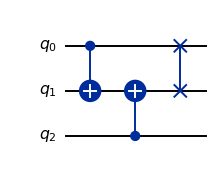

In [8]:
qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.cx(2, 1)
qc.swap(0, 1)
qc.draw('mpl', scale=0.7)

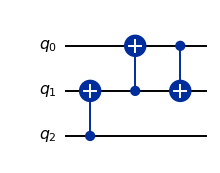

In [9]:
tket_pass(qc).draw('mpl', scale=0.7)

Pattern 2: CNOT-Exchange-Z

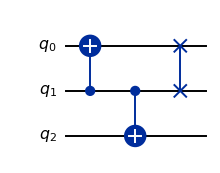

In [77]:
qc = QuantumCircuit(3)
qc.cx(1, 0)
qc.cx(1, 2)
qc.swap(0, 1)
qc.draw('mpl', scale=0.7)

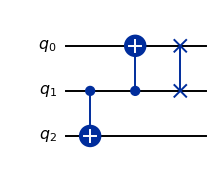

In [93]:
qc_ = QuantumCircuit(3)
qc_.cx(1, 2)
qc_.cx(1, 0)
qc_.swap(0, 1)
qc_.draw('mpl', scale=0.7)

Pattern 3: CNOT-Ladder-L

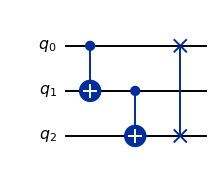

In [141]:
qc = QuantumCircuit(3)
# qc.append(UnitaryGate(cirq.testing.random_unitary(4), label='SU(4)'), [0, 2])
qc.cx(0,1)
qc.cx(1,2)
qc.swap(0,2)
qc.draw('mpl', scale=0.7)

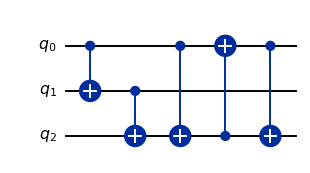

In [142]:
# Generally, 不能被简化
tket_pass(qc).draw('mpl', scale=0.7)

In [149]:
circ = qml.tape.QuantumScript([
    qml.CNOT((1, 2)),
    qml.CNOT((2, 3)),
    qml.SWAP((1, 3)),
], [])

print(qml.drawer.tape_text(circ, show_all_wires=True))

1: ─╭●────╭SWAP─┤  
2: ─╰X─╭●─│─────┤  
3: ────╰X─╰SWAP─┤  


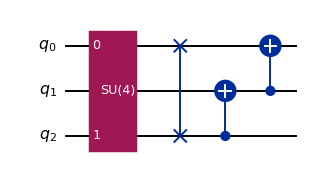

In [133]:
# 但是有两个其他的优化点

# 1) qubit dependency is all2all，所以当前面再有其他的 q0 <-> q2 两比特门的话，把 SWAP bypass 过去
qc1 = QuantumCircuit(3)
qc1.append(UnitaryGate(cirq.testing.random_unitary(4), label='SU(4)'), [0, 2])
qc1.swap(0, 2)
qc1.cx(2,1)
qc1.cx(1,0)
qc1.draw('mpl', scale=0.7)

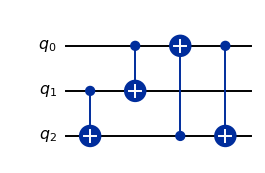

In [134]:
# 2) 利用 CNOT ladder 变换关系，把 SWAP 开销降低成 iSWAP 开销


qc2 = QuantumCircuit(3)
qc2.cx(1,2)
qc2.cx(0,1)

qc2.cx(2, 0)
qc2.cx(0, 2)

qc2.draw('mpl', scale=0.7)

In [ ]:
qc_to_unitary(qc).real

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.]])

In [128]:
qc_to_unitary(qc2).real == qc_to_unitary(qc).real

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

Pattern 3: CNOT-Ladder-R

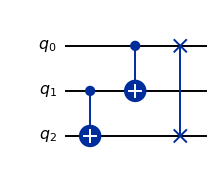

In [135]:
qc = QuantumCircuit(3)
qc.cx(1,2)
qc.cx(0,1)
qc.swap(0,2)
qc.draw('mpl', scale=0.7)

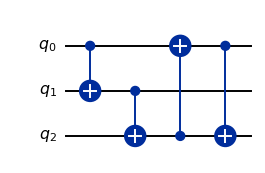

In [138]:
# 2) 利用 CNOT ladder 变换关系，把 SWAP 开销降低成 iSWAP 开销

qc2 = QuantumCircuit(3)
qc2.cx(0,1)
qc2.cx(1,2)

qc2.cx(2, 0)
qc2.cx(0, 2)

qc2.draw('mpl', scale=0.7)

### Other optimization opportunities

Following circuit snippet ~ iSWAP

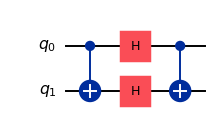

In [ ]:
circ = pytket.Circuit(2)
circ.CX(0, 1).H(0).H(1).CX(0, 1)
tket_to_qiskit(circ).draw('mpl', scale=0.7)

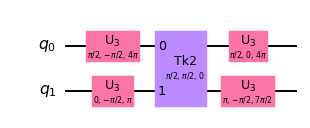

In [32]:
pytket.passes.FullPeepholeOptimise(allow_swaps=False, target_2qb_gate=OpType.TK2).apply(circ)
tket_to_qiskit(circ).draw('mpl', scale=0.7, style='clifford')

Following circuit snippet ~ CNOT

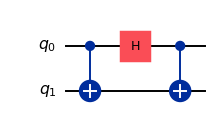

In [34]:
circ = pytket.Circuit(2)
circ.CX(0, 1).H(0).CX(0, 1)
tket_to_qiskit(circ).draw('mpl', scale=0.7)

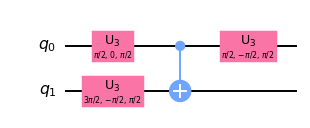

In [37]:
pytket.passes.FullPeepholeOptimise(allow_swaps=False, target_2qb_gate=OpType.CX).apply(circ)
tket_to_qiskit(circ).draw('mpl', scale=0.7, style='clifford')

In [3]:
from qiskit.circuit.random import random_circuit
from pytket.extensions.qiskit import qiskit_to_tk
from qiskit import QuantumCircuit

# 使用 Qiskit 生成随机电路（5 量子比特，深度 3）
# qiskit_circ = random_circuit(10, depth=10, max_operands=2, measure=False)
# pytket_circ = qiskit_to_tk(qiskit_circ)

qiskit_circ = QuantumCircuit.from_qasm_file('qiskit_circ.qasm')
pytket_circ = qiskit_to_tket(qiskit_circ)


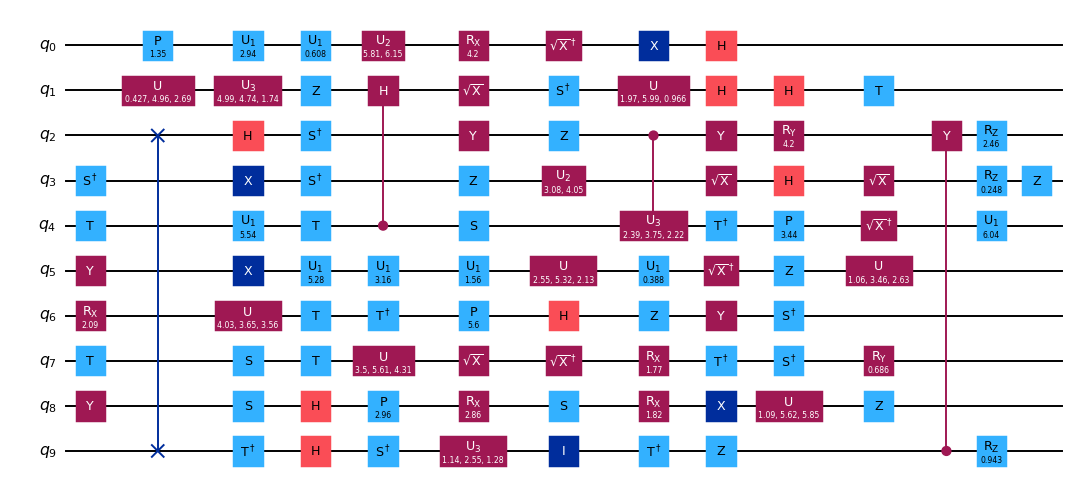

In [4]:
qiskit_circ.draw('mpl', scale=0.7)

In [5]:

from regulus.transforms import rebase
from qiskit import qasm2
import regulus



In [6]:
qasm2.dump(qiskit_circ, 'qiskit_circ.qasm')

In [7]:
circ = regulus.Circuit.from_qasm(fname='qiskit_circ.qasm')

In [8]:
circ = regulus.transforms.rebase.rebase_to_canonical(circ)

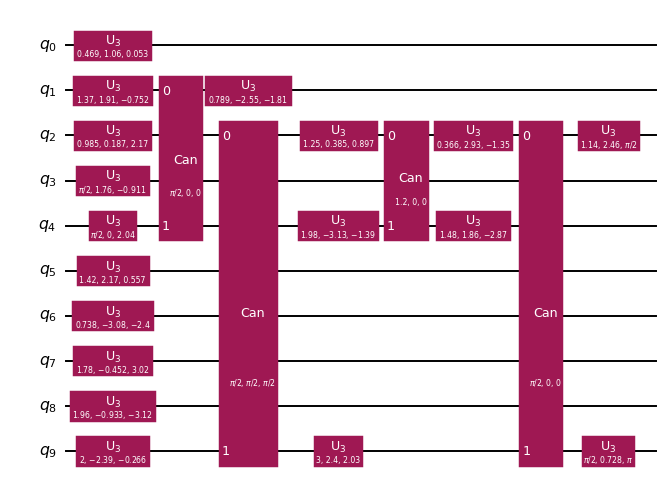

In [9]:
circ.to_qiskit().draw('mpl', scale=0.7)

In [10]:
from pytket.circuit.display import render_circuit_jupyter



c = pytket_circ.copy()

# pytket.passes.FullPeepholeOptimise(allow_swaps=False, target_2qb_gate=OpType.TK2).apply(c)
pytket.passes.SynthesiseTK().apply(c)
# pytket.passes.FullPeepholeOptimise(allow_swaps=False).apply(c)


True

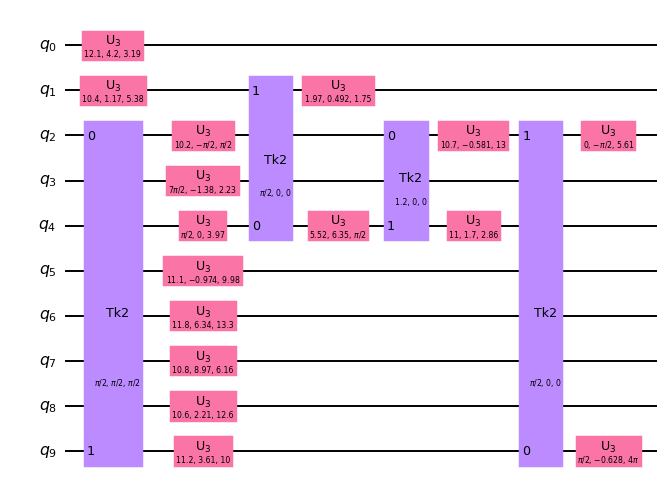

In [11]:
tket_to_qiskit(c).draw('mpl', scale=0.7, style='clifford')

In [12]:
from pytket.utils.stats import gate_counts
gate_counts(pytket_circ)

Counter({OpType.U1: 12,
         OpType.U3: 9,
         OpType.H: 8,
         OpType.Z: 8,
         OpType.Sdg: 7,
         OpType.T: 6,
         OpType.Y: 5,
         OpType.Rx: 5,
         OpType.Tdg: 5,
         OpType.X: 4,
         OpType.S: 4,
         OpType.SX: 4,
         OpType.SXdg: 4,
         OpType.Rz: 3,
         OpType.U2: 2,
         OpType.Ry: 2,
         OpType.SWAP: 1,
         OpType.CH: 1,
         OpType.CU3: 1,
         OpType.noop: 1,
         OpType.CY: 1})

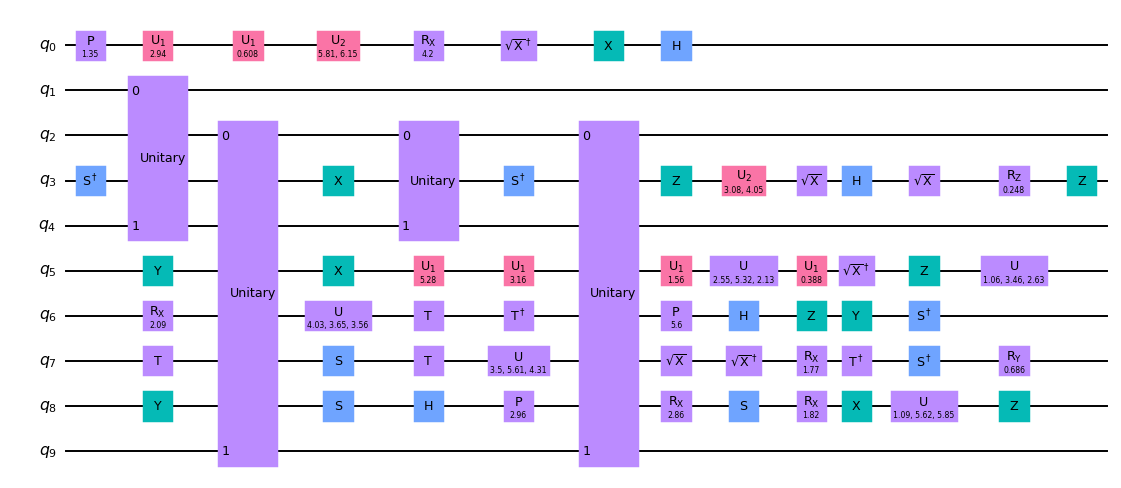

In [13]:
from qiskit.transpiler.passes import ConsolidateBlocks
from qiskit.transpiler import PassManager

pm = PassManager([ConsolidateBlocks(force_consolidate=True)])
pm.run(qiskit_circ).draw('mpl', scale=0.7, style='clifford')

In [35]:
gate_counts(pytket.qasm.circuit_from_qasm_str(circ.to_qasm()))

Counter({OpType.U3: 18, OpType.CustomGate: 4})

In [37]:
OpType.CustomGate

OpType.CustomGate

In [40]:
circ_tket = pytket.qasm.circuit_from_qasm_str(circ.to_qasm())
circ_tket.ops_of_type(OpType.CustomGate)[0]


can(0.5,0.0,0.0)

In [ ]:
circ_tket.ops_of_type(OpType.CustomGate)[0]

array([[ 5.00000000e-01-5.00000000e-01j,  1.23259516e-32+5.88784672e-17j,
         1.37383090e-16-7.85046229e-17j, -5.00000000e-01-5.00000000e-01j],
       [-1.96261557e-17+1.57009246e-16j,  5.00000000e-01-5.00000000e-01j,
        -5.00000000e-01-5.00000000e-01j,  3.92523115e-17-9.81307787e-17j],
       [-5.88784672e-17+4.01610584e-33j, -5.00000000e-01-5.00000000e-01j,
         5.00000000e-01-5.00000000e-01j, -3.92523115e-17-1.96261557e-17j],
       [-5.00000000e-01-5.00000000e-01j, -1.57009246e-16-1.96261557e-17j,
        -5.88784672e-17+7.85046229e-17j,  5.00000000e-01-5.00000000e-01j]])

In [14]:
from pytket.circuit import CustomGateDef, CustomGate
import numpy as np
# 定义 SqrtISWAP 的矩阵



sqisw_circ = pytket.Circuit(2)
# [TK1(0, 0, 0.5) q[0];, TK1(0, 0, 3.5) q[1];, TK2(0.25, 0.25, 0) q[0], q[1];, TK1(0, 0, 1.5) q[0];, TK1(0, 0, 2.5) q[1];]
sqisw_circ.add_gate(OpType.TK1, [0, 0, 0.5], [0])
sqisw_circ.add_gate(OpType.TK1, [0, 0, 3.5], [1])
sqisw_circ.add_gate(OpType.TK2, [0.25, 0.25, 0], [0, 1])
sqisw_circ.add_gate(OpType.TK1, [0, 0, 1.5], [0])
sqisw_circ.add_gate(OpType.TK1, [0, 0, 2.5], [1])

# 创建 CustomGateDef 对象
sqrt_iswap_def = CustomGateDef.define(
    "√iSWAP",  # 门名称
    sqisw_circ, []
)

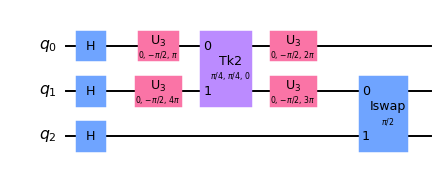

In [15]:
ccc = pytket.Circuit(3)
ccc.H(0).H(1).H(2)
ccc.add_gate(CustomGate(sqrt_iswap_def, []), [0, 1])
ccc.add_gate(OpType.ISWAP, 0.5, [1, 2])
tket_to_qiskit(ccc).draw('mpl', scale=0.7, style='clifford')

In [16]:
render_circuit_jupyter(ccc)

In [17]:
pytket.passes.RebaseCustom({OpType.ISWAP, OpType.TK1}, allow_swaps=False).apply(ccc)

TypeError: RebaseCustom(): incompatible function arguments. The following argument types are supported:
    1. RebaseCustom(gateset: collections.abc.Set[pytket._tket.circuit.OpType], cx_replacement: pytket._tket.circuit.Circuit, tk1_replacement: collections.abc.Callable[[typing.Union[sympy.Expr, float], typing.Union[sympy.Expr, float], typing.Union[sympy.Expr, float]], pytket._tket.circuit.Circuit]) -> pytket._tket.passes.BasePass
    2. RebaseCustom(gateset: collections.abc.Set[pytket._tket.circuit.OpType], tk2_replacement: collections.abc.Callable[[typing.Union[sympy.Expr, float], typing.Union[sympy.Expr, float], typing.Union[sympy.Expr, float]], pytket._tket.circuit.Circuit], tk1_replacement: collections.abc.Callable[[typing.Union[sympy.Expr, float], typing.Union[sympy.Expr, float], typing.Union[sympy.Expr, float]], pytket._tket.circuit.Circuit]) -> pytket._tket.passes.BasePass

Invoked with types: set, kwargs = { allow_swaps: bool }

In [18]:
from pytket.circuit import Op, OpType

Op.create(OpType.TK2, [0.1, 0.2, 0.3]).get_unitary


In [56]:
cirq.unitary(cirq.SQRT_ISWAP).round(4).real

array([[1.    , 0.    , 0.    , 0.    ],
       [0.    , 0.7071, 0.    , 0.    ],
       [0.    , 0.    , 0.7071, 0.    ],
       [0.    , 0.    , 0.    , 1.    ]])

In [ ]:
from bqskit.ir.gates import SqrtISwapGate

In [34]:
# ops = cirq.two_qubit_matrix_to_sqrt_iswap_operations(*cirq.LineQubit.range(2), sqisw_circ.get_unitary())
# ops = cirq.two_qubit_matrix_to_sqrt_iswap_operations(*cirq.LineQubit.range(2), cirq.testing.random_unitary(4))
ops = cirq.two_qubit_matrix_to_sqrt_iswap_operations(*cirq.LineQubit.range(2), Op.create(OpType.ISWAPMax).get_unitary())


In [35]:
cirq.Circuit(ops)

0: ───S───iSwap───────iSwap──────────────
          │           │
1: ───────iSwap^0.5───iSwap^0.5───S^-1───

In [36]:
from pytket.extensions.cirq import cirq_to_tk

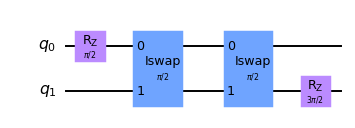

In [37]:
cc = cirq_to_tk(cirq.Circuit(ops))

tket_to_qiskit(cc).draw('mpl', scale=0.7, style='clifford')

In [127]:
from cirq.value import BitMaskKeyCondition

ImportError: cannot import name 'BitMaskKeyCondition' from 'cirq.value' (/Users/anan/miniconda3/lib/python3.12/site-packages/cirq/value/__init__.py)

In [116]:
cirq.ISwapPowGate

cirq.ops.swap_gates.ISwapPowGate

In [114]:
type(ops[0].qubits[0].index)

AttributeError: 'LineQubit' object has no attribute 'index'

In [53]:
(cc.get_commands()[1].op.params[0])

0.5

In [47]:
cc

[Rz(0.5) q[0]; ISWAP(0.5) q[0], q[1]; ISWAP(0.5) q[0], q[1]; Rz(1.5) q[1]; ]